## 📌 Hypothesis
> "배송 지연 여부는 고객 리뷰 평점에 유의미한 영향을 미친다."

## 📌 Data Scope & Unit of Analysis
- 분석 단위: 주문(order_id) 기준
- 주문 상태가 'delivered'인 건만 분석 대상에 포함
- 리뷰 데이터는 order_id 기준으로 집계하여 1행 = 1주문이 되도록 정규화

## 📌 Metric Definition
- review_score: 고객 리뷰 평점 (1~5)
- is_late: 실제 배송일이 예상 배송일을 초과한 경우 1, 그렇지 않으면 0

## 📌 Data Validation
- reviews 테이블에서 하나의 주문에 여러 리뷰가 존재할 경우
조인 시 주문 단위가 깨지기 때문에 해당 가능성을 검토
- order_id 기준으로 집계한 뒤 조인 → 최종 데이터프레임에서 order_id의 유일성을 재검증

## 📌 Statistical Validation
- 표본 수, 평균
- Welch t-test + Cohen’s d

## 📌 Analysis & Validation
1. 배송 지연에 따른 평균 평점 비교 분석
    - 배송 지연 여부에 따른 평균 리뷰 점수 비교
    - 분포 차이 확인을 위한 시각화
2. 통계 검증
    - 평균 차이 t-test 검증
    - 효과크기(Cohen’s d): 평균 차이의 실질적 크기를 확인

In [ ]:
import pandas as pd
import numpy as np
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

In [ ]:
# DB 연결
conn = sqlite3.connect("olist.db")

In [ ]:
# SQLite에 CSV 적재
path = '/content/drive/MyDrive/Data Analysis/prj1-olist-ecommerce'

pd.read_csv(f"{path}/datasets/raw/olist_orders_dataset.csv").to_sql("orders", conn, if_exists="replace", index=False)
pd.read_csv(f"{path}/datasets/raw/olist_order_reviews_dataset.csv").to_sql("reviews", conn, if_exists="replace", index=False)

99224

In [ ]:
# reviews table에 order_id가 여러 개인지 확인
dup_check_query = """
  SELECT
    order_id
    , count(*) AS review_cnt
  FROM reviews
  GROUP BY order_id
  HAVING COUNT(*) > 1
  ORDER BY review_cnt DESC
  LIMIT 10
  ;
"""

pd.read_sql_query(dup_check_query, conn)

,order_id,review_cnt
0,df56136b8031ecd28e200bb18e6ddb2e,3
1,c88b1d1b157a9999ce368f218a407141,3
2,8e17072ec97ce29f0e1f111e598b0c85,3
3,03c939fd7fd3b38f8485a0f95798f1f6,3
4,ffaabba06c9d293a3c614e0515ddbabc,2
5,ff850ba359507b996e8b2fbb26df8d03,2
6,ff763b73e473d03c321bcd5a053316e8,2
7,fe041ba1c9f54016432fa6ee91709dbc,2
8,fd95ae805c63c534f1a64589e102225e,2
9,fd61441ba2a7b57e6342862e779b10b0,2


In [ ]:
# 중복 리뷰 집계 (중복리뷰가 얼마나 있는지)
dup_summary_query = """
  SELECT
    SUM(CASE
      WHEN review_cnt > 1 THEN 1
      ELSE 0
      END
    ) AS orders_with_dup_reviews
    , COUNT(*) AS total_order
  FROM(
    SELECT
      order_id
      , COUNT(*) AS review_cnt
    FROM reviews
    GROUP BY order_id
  )
  ;
"""

pd.read_sql_query(dup_summary_query, conn)

,orders_with_dup_reviews,total_order
0,547,98673


In [ ]:
# 중복 처리 (평균) 및 dataframe으로 불러오기
query = """
  WITH reviews_agg AS (
  SELECT
    order_id,
    AVG(review_score) AS review_score,
    COUNT(*) AS review_cnt
  FROM reviews
  GROUP BY order_id
)
SELECT
  o.order_id,
  o.order_status,
  o.order_purchase_timestamp,
  o.order_delivered_customer_date,
  o.order_estimated_delivery_date,
  r.review_score,
  r.review_cnt
FROM orders o
LEFT JOIN reviews_agg r
  ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
;
"""

df = pd.read_sql_query(query, conn)

In [ ]:
# order_id 중복 여부 더블체크
print("order_id 개수:", df['order_id'].nunique())
print("전체 행 개수:", len(df))
print("중복된 order_id 개수:", df['order_id'].duplicated().sum())

order_id 개수: 96478
전체 행 개수: 96478
중복된 order_id 개수: 0


In [ ]:
# 연결 close
conn.close()

In [ ]:
# 데이터 확인
display(df.sample(5))
display(df.info())

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_cnt
16998,b014baa6612826328ffeeb79fd3fa596,delivered,2017-11-18 17:22:43,2017-11-29 21:13:25,2017-12-12 00:00:00,4.0,1.0
68657,dcfb709b0757c7e96301c882821adb2c,delivered,2017-10-14 11:18:59,2017-10-19 18:42:45,2017-11-01 00:00:00,5.0,1.0
32018,5bcde4ca8f0878aab60dc18cc310fa4d,delivered,2018-07-18 11:53:31,2018-07-23 17:31:04,2018-08-03 00:00:00,5.0,1.0
89326,cb1ef5be56747ab6c5ef7271ecf4e12c,delivered,2017-11-02 11:19:16,2017-11-23 20:48:54,2017-11-30 00:00:00,5.0,1.0
34090,93694762710b53132d45f1a0aa2d05db,delivered,2017-04-16 20:13:57,2017-04-21 10:43:30,2017-05-10 00:00:00,4.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       96478 non-null  object 
 1   order_status                   96478 non-null  object 
 2   order_purchase_timestamp       96478 non-null  object 
 3   order_delivered_customer_date  96470 non-null  object 
 4   order_estimated_delivery_date  96478 non-null  object 
 5   review_score                   95832 non-null  float64
 6   review_cnt                     95832 non-null  float64
dtypes: float64(2), object(5)
memory usage: 5.2+ MB


None

In [ ]:
# timestamp 타입 변환
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

In [ ]:
# 필수 컬럼 결측치 비율 확인
key_cols = ['order_delivered_customer_date','order_estimated_delivery_date','review_score']
print(df[key_cols].isna().mean().sort_values(ascending=False))

review_score                     0.006696
order_delivered_customer_date    0.000083
order_estimated_delivery_date    0.000000
dtype: float64


In [ ]:
# 분석 불가능한 row 제거
df = df[df['review_score'].notna()]
df = df[df['order_delivered_customer_date'].notna()]

#### ✅ 결측치 처리
- review_score는 분석의 핵심 종속변수이므로 결측치는 임의 대체하지 않고 분석 대상에서 제외
- 배송 완료일 결측 데이터는 배송 지연 여부를 정의할 수 없어 제외
- 두 결측치 모두 전체의 1% 미만으로 분석 결과에 미치는 영향은 제한적이라고 판단

In [ ]:
# 배송 예정일에 시간 지정 여부 확인
df['order_estimated_delivery_date'].dt.time.describe()

,order_estimated_delivery_date
count,95824
unique,1
top,00:00:00
freq,95824


In [ ]:
# 배송 마감일을 배송 예정일의 23:59:59로 설정
df['estimated_deadline'] = df['order_estimated_delivery_date'] + pd.Timedelta('23:59:59')

In [ ]:
# 지연 여부 판단
df['is_late'] = (df['order_delivered_customer_date'] > df['estimated_deadline']).astype(int)

#### ✅ is_late (배송 지연 여부) 파생 컬럼 생성
- 배송 완료일시가 배송 마감일보다 클 경우 지연으로 판단
- is_late가 1일 경우 지연 배송 / 0일 경우 정시 혹은 조기 배송

In [ ]:
# 지연 여부에 따른 평점 평균 변화 확인
summary = df.groupby('is_late').agg(
    avg_review = ('review_score', 'mean')
    , cnt = ('review_score', 'count')
)
display(summary)

avg_diff = summary.loc[0]['avg_review'] - summary.loc[1]['avg_review']
print("평균 평점 하락치: ", round(avg_diff, 3))

avg_diff_ratio = avg_diff / summary.loc[0]['avg_review']
print("평균 평점 하락율: ", round(avg_diff_ratio, 3))

,avg_review,cnt
is_late,,
0,4.290589,89443
1,2.271823,6381


평균 평점 하락치:  2.019
평균 평점 하락율:  0.471


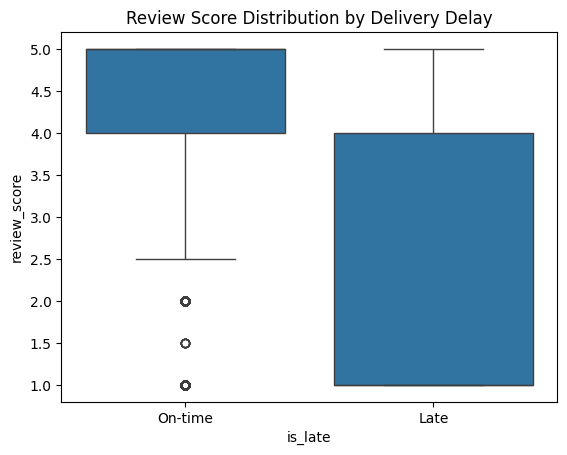

In [ ]:
# 지연 여부에 따른 평점 분포 시각화 1 (boxplot)
sns.boxplot(
    data = df
    , x = 'is_late'
    , y = 'review_score'
)

plt.xticks([0, 1], ['On-time', 'Late'])
plt.title('Review Score Distribution by Delivery Delay')
plt.show()

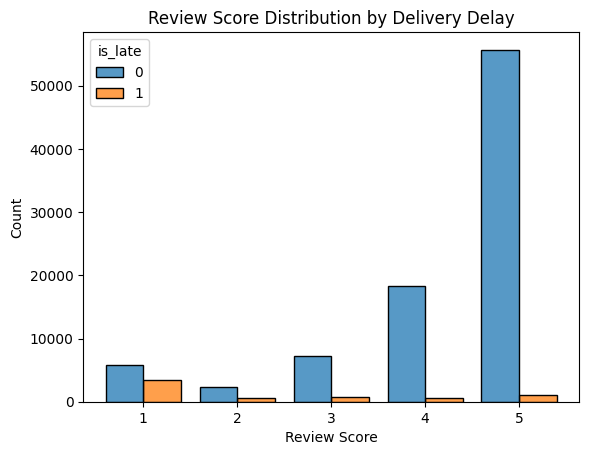

In [ ]:
# 지연 여부에 따른 평점 분포 시각화 2 (histogram)
sns.histplot(
    data=df
    , x='review_score'
    , hue='is_late'
    , bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    , multiple='dodge'
    , shrink=0.8
)

plt.xticks([1, 2, 3, 4, 5])
plt.title('Review Score Distribution by Delivery Delay')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

In [ ]:
# 그룹 정의
on_time = df[(df['is_late'] == 0) & (df['review_score'].notna())]['review_score']
late = df[(df['is_late'] == 1) & (df['review_score'].notna())]['review_score']

In [ ]:
# 표본 수
n1, n2 = len(on_time), len(late)

# 평균
mean1, mean2 = on_time.mean(), late.mean()

In [ ]:
# t-test 검증
t_stat, p_value = ttest_ind(on_time, late, equal_var=False)

In [ ]:
# 효과크기 (Cohen's d) 검증
pooled_sd = np.sqrt((on_time.var(ddof=1) + late.var(ddof=1)) / 2)
cohens_d = (mean1 - mean2) / pooled_sd

In [ ]:
# 결과 출력
p_value_str = "< 1e-10" if p_value < 1e-10 else f"{p_value:.4f}"

print(f"on_time: n={n1:,}, mean={mean1:.2f}")
print(f"late: n={n2:,}, mean={mean2:.2f}\n")

print(f"평점 평균 차이 : {mean1 - mean2:.2f}")
print(f"Cohen's d: {cohens_d:.2f}")
print(f"p-value: {p_value_str}")

on_time: n=89,443, mean=4.29
late: n=6,381, mean=2.27

평점 평균 차이 : 2.02
Cohen's d: 1.47
p-value: < 1e-10


## 📌 Result Summary
- 지연 발생 시 평점이 4.3에서 2.3으로 약 47% 폭락
- 분포상 낮은 평점(1~2점) 비중이 지연 주문에서 뚜렷하게 증가
- 충분한 표본 수를 바탕으로 통계적으로도 유의미한 차이를 확인

## 📌 Limitations & Next Step
- 배송 지연과 리뷰 평점 간의 인과관계를 직접적으로 증명하지는 못함
- 다음 단계에서 지연 일수별 임계점을 분석

In [ ]:
# dataframe 저장
df.to_csv(
    f"{path}/datasets/processed/olist_orders_enriched.csv"
    , index=False
    , encoding="utf-8-sig"
)